In [188]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pickle
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import SGD

In [3]:
images = []
labels = [] # dogs = 1 # wolfs = 0

for root, dirs, files in os.walk('data'):
    for name in files:
            file_name = os.path.join(root, name)
            labels.append(int('dogs' in file_name))
            image = cv2.imread(file_name, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

with open('dog_wolf_files.sav', 'wb') as outfile:
    pickle.dump((labels, images), outfile)

In [3]:
with open('dog_wolf_files.sav', 'rb') as infile:
    labels, images = pickle.load(infile)

In [4]:
len(labels)
len(images)

2000

In [20]:
class ImageScaler:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def scale(self, images):
        if type(images) is list:
            image_list = [self.scale(image) for image in images]
            return image_list
        else:
            resized_image = cv2.resize(images, (self.height, self.width))
            return resized_image / 255.0

In [21]:
scaler = ImageScaler(width=50, height=50)
scaled_images = scaler.scale(images)



In [22]:
train_images, test_images, train_labels, test_labels = train_test_split(scaled_images, labels, shuffle=True)


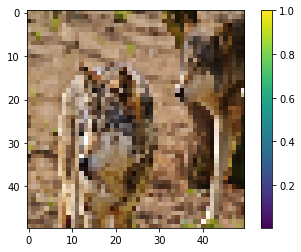

In [125]:
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
train_images = tf.reshape(train_images, [-1, 50, 50, 3])
test_images = tf.reshape(test_images, [-1, 50, 50, 3])

In [268]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(scaler.height, scaler.width, 3), padding='same'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.Flatten(input_shape=(scaler.height, scaler.width, 3)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [269]:
model.fit(train_images,  np.array(train_labels), epochs=20)

Epoch 1/20
47/47 [==============================] - 2s 47ms/step - loss: 0.6838 - accuracy: 0.5660

In [270]:
test_loss, test_acc = model.evaluate(test_images,  np.array(test_labels), verbose=2)

16/16 - 0s - loss: 1.3295 - accuracy: 0.7200


In [271]:
predictions = model.predict(train_images)

In [279]:
predictions[700]

array([2.1918893e-02, 7.6762090e-06], dtype=float32)

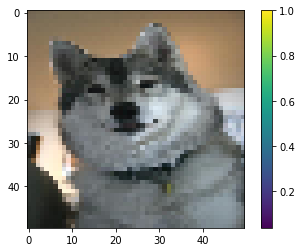

In [280]:
plt.figure()
plt.imshow(train_images[700])
plt.colorbar()
plt.grid(False)
plt.show()